In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv

In [2]:
# A simple GNN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Data(x=[100, 5], edge_index=[2, 505], y=[100])


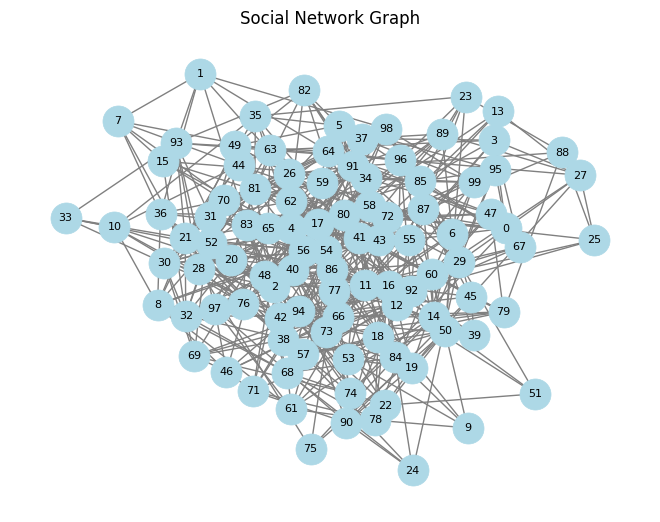

In [3]:
import numpy as np
# Number of nodes (users)
num_nodes = 100

# Each node has a feature vector of length 5
num_node_features = 5

# Number of classes (e.g., interest groups)
num_classes = 3

# Generate random node features
node_features = torch.rand((num_nodes, num_node_features))

# Create a simple graph using networkx and convert it to edge index
G = nx.erdos_renyi_graph(n=num_nodes, p=0.1)
edge_index = torch.tensor([list(edge) for edge in G.edges], dtype=torch.long).t().contiguous()

# Create random labels for each node (e.g., 3 interest groups)
labels = np.zeros(num_nodes)

# Iterate over each node
for node in range(num_nodes):
    # Get the neighbors of the current node
    neighbors = list(G.neighbors(node))
    
    # Check if any neighbor has a label
    for neighbor in neighbors:
        if labels[neighbor] != 0:
            # Increase the likelihood of the current node having the same label as the neighbor
            labels[node] = labels[neighbor]
            break
    
    # If no neighbor has a label, assign a random label
    if labels[node] == 0:
        labels[node] = np.random.randint(1, num_classes + 1)

# Convert the labels to a PyTorch tensor
labels = torch.tensor(labels, dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

print(data)

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, linewidths=0.5, font_size=8)
plt.title("Social Network Graph")
plt.show()

In [4]:
# Initialize the model
model = GCN(num_node_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [5]:
# moving the data to GPU
data = data.to('cuda')
model.to('cuda')

GCN(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 3)
)

In [6]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

# Testing function
def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        test_logits = logits[test_mask]
        test_labels = data.y[test_mask]
        pred = test_logits.max(1)[1]
        correct = pred.eq(test_labels).sum().item()
        accuracy = correct / test_mask.sum().item()
    return accuracy

# Split the data into training and testing
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Randomly select 80% of the nodes for training and the rest for testing
train_size = int(num_nodes * 0.8)
test_size = num_nodes - train_size
indices = torch.randperm(num_nodes)
data.train_mask[indices[:train_size]] = True
data.test_mask[indices[train_size:]] = True

In [7]:
# Run the training
for epoch in range(100):
    loss = train()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 1.3124
Epoch 2, Loss: 1.2102
Epoch 3, Loss: 1.1170
Epoch 4, Loss: 0.9835
Epoch 5, Loss: 0.9656
Epoch 6, Loss: 0.9140
Epoch 7, Loss: 0.9185
Epoch 8, Loss: 0.7748
Epoch 9, Loss: 0.8993
Epoch 10, Loss: 0.7465
Epoch 11, Loss: 0.7148
Epoch 12, Loss: 0.7292
Epoch 13, Loss: 0.7345
Epoch 14, Loss: 0.7469
Epoch 15, Loss: 0.7513
Epoch 16, Loss: 0.6983
Epoch 17, Loss: 0.7027
Epoch 18, Loss: 0.7234
Epoch 19, Loss: 0.6637
Epoch 20, Loss: 0.6572
Epoch 21, Loss: 0.6794
Epoch 22, Loss: 0.5931
Epoch 23, Loss: 0.6222
Epoch 24, Loss: 0.6408
Epoch 25, Loss: 0.6900
Epoch 26, Loss: 0.5912
Epoch 27, Loss: 0.6562
Epoch 28, Loss: 0.6525
Epoch 29, Loss: 0.5893
Epoch 30, Loss: 0.5313
Epoch 31, Loss: 0.5083
Epoch 32, Loss: 0.6175
Epoch 33, Loss: 0.6885
Epoch 34, Loss: 0.5764
Epoch 35, Loss: 0.6017
Epoch 36, Loss: 0.5874
Epoch 37, Loss: 0.5590
Epoch 38, Loss: 0.6327
Epoch 39, Loss: 0.5551
Epoch 40, Loss: 0.6154
Epoch 41, Loss: 0.6004
Epoch 42, Loss: 0.6026
Epoch 43, Loss: 0.6189
Epoch 44, Loss: 0.62

In [8]:
# Test the model
accuracy = test()
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6500
